### Computing Optimal Policy using DDQN

Implementing DDQN to find optimal policy on Taxi-v3 environment


The taxi-v3 environment consists of a 5x5 grid world where a taxi must pick up a passenger at one location and drop them off at another. 

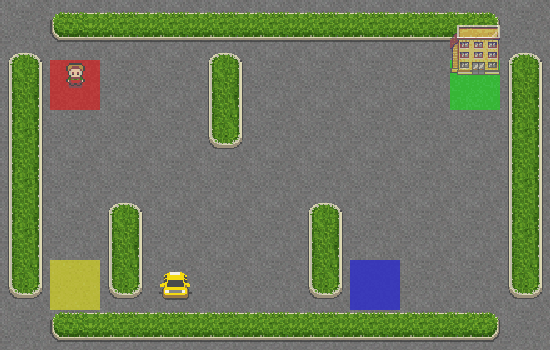

There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.

The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends. The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received. There is always one passenger at a time. After a successful drop-off, the environment resets with a new passenger and new destination.

The state is represented as an integer from 0 to 499, which encodes:
* Taxi's position (5×5 grid = 25 locations)
* Passenger's location (4 locations + inside the taxi = 5 states)
* Destination location (4 possible locations) , 
25 × 5 × 4 = 500 unique states.

Each state has three values - (taxi position, passenger location, passenger destination)

Starting space: The initial state is sampled uniformly from the possible states where the passenger is neither at their destination nor inside the taxi. There are 300 possible initial states: 25 taxi positions, 4 passenger locations (excluding inside the taxi) and 3 destinations (excluding the passenger’s current location).

The action space consists of 6 possible actions: 
* 0: Move south
* 1: Move north
* 2: Move east
* 3: Move west
* 4: Pick up passenger
* 5: Drop off passenger

Rewards:
* +20: for successfully dropping the passenger at the correct location.
* -1: for each time step to encourage efficiency.
* -10: for attempting an invalid pickup or drop-off.

The episode ends if the following happens:
* Termination: 1. The taxi drops off the passenger.
* Truncation (when using the time_limit wrapper): 1. The length of the episode is 200.

DQN overestimates Q-values because it uses the same network to select and evaluate actions.

DDQN Uses policy_net to select the best action and target_net to evaluate that action's value.

In [1]:
# import statements
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [3]:
# Load Taxi environment
env = gym.make("Taxi-v3")

In [4]:
random.seed(0)

In [5]:
# Define DQN Model

# To approximate Q-values for each state-action pair.
# The input state is one-hot encoded (converted into a vector representation).
# Fully connected layers process the state and produce Q-values for all possible actions.
# The output is a vector where each value corresponds to the expected future reward of taking a certain action.

class DDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 64)         # Second fully connected layer
        self.fc3 = nn.Linear(64, action_size) # Output layer
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Output raw Q-values

In [6]:
# Hyperparameters
state_size = env.observation_space.n
action_size = env.action_space.n
learning_rate = 0.001
gamma = 0.95  # Discount factor
epsilon = 0.8  # Initial exploration probability
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 5
max_memory_size = 10000
episodes = 5
max_steps=5
target_update = 2  # How often to update the target network

In [7]:
# Initialize networks
policy_net = DDQN(state_size, action_size) #Learns the Q-values.
target_net = DDQN(state_size, action_size) #Provides stable target values
target_net.load_state_dict(policy_net.state_dict())  # Copy initial weights

target_net.eval()  # Target network is in eval mode

DDQN(
  (fc1): Linear(in_features=500, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)

In [8]:
# Optimizer and loss
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [9]:
# Experience replay buffer

#  stores past experiences and samples them randomly to break correlations for stable learning.

memory = deque(maxlen=max_memory_size)

In [12]:
# Training loop
reward_list = []

for episode in range(episodes):
    print('Episode',episode)
    state, _ = env.reset()
    total_reward = 0
    done = False
    print('before epsilon',epsilon)
    for step in range(max_steps):
        # The state is one-hot encoded to convert it into a tensor.
        state_tensor = torch.eye(state_size)[state].unsqueeze(0)  
        
        # Select action using epsilon-greedy strategy
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Exploration
        else:
            with torch.no_grad():
                # Select best actions from policy network
                best_next_actions = policy_net(next_state_batch).argmax(1)

                # Evaluate those actions using target network
                max_next_Q = target_net(next_state_batch).gather(1, best_next_actions.unsqueeze(1)).squeeze()

                target_Q_values = reward_batch + gamma * max_next_Q * (~done_batch)

        print('Before making the action',state_tensor,action)
        # Take action and observe reward
        next_state, reward, done, truncated, _ = env.step(action)
        print('After making the action',next_state, reward, done, truncated)
        total_reward += reward
        
        # Store experience in memory
        memory.append((state, action, reward, next_state, done))
        print('memory',memory)
        state = next_state
        
        if done:
            break
    
        # Train the DQN if memory has enough samples
        if len(memory) > batch_size:
            batch = random.sample(memory, batch_size)
            
            # Extracts data from batch and converts them into PyTorch tensors for training.
            # Converts each state into a one-hot encoded tensor.
            state_batch = torch.eye(state_size)[[s[0] for s in batch]]
            action_batch = torch.tensor([s[1] for s in batch], dtype=torch.long) #stores action taken
            reward_batch = torch.tensor([s[2] for s in batch], dtype=torch.float) #stores rewards received
            next_state_batch = torch.eye(state_size)[[s[3] for s in batch]] #stores next state to compute Q values
            done_batch = torch.tensor([s[4] for s in batch], dtype=torch.bool)
            
            # Compute Q-values - Predicts Q-values for all actions in each state and 
            # Selects only the Q-values for the chosen actions.
            current_Q_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze()
            print('current_Q_values',current_Q_values)
            
            # Compute target Q-values
            # Uses target network to estimate future rewards.
            with torch.no_grad():
                # Step 1: Select best action using the current policy network
                best_next_actions = policy_net(next_state_batch).argmax(1)

                # Step 2: Evaluate that action's value using the target network
                max_next_Q = target_net(next_state_batch).gather(1, best_next_actions.unsqueeze(1)).squeeze()

                # Step 3: Compute target Q-values
                target_Q_values = reward_batch + gamma * max_next_Q * (~done_batch)

            # Compute loss and update network
            loss = loss_fn(current_Q_values, target_Q_values) # Measures the difference between predicted Q-values and target Q-values.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() # Updates policy network weights.
    
    # Decay epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    print('after decaying epsilon',epsilon)
    
    # Update target network every few episodes
    if (episode + 1) % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    reward_list.append(total_reward)
    
    if (episode + 1) % 200 == 0:
        print(f"Episode {episode+1}/{episodes}, Reward: {total_reward}, Epsilon: {epsilon:.4f}")

Episode 0
before epsilon 0.796
Before making the action tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

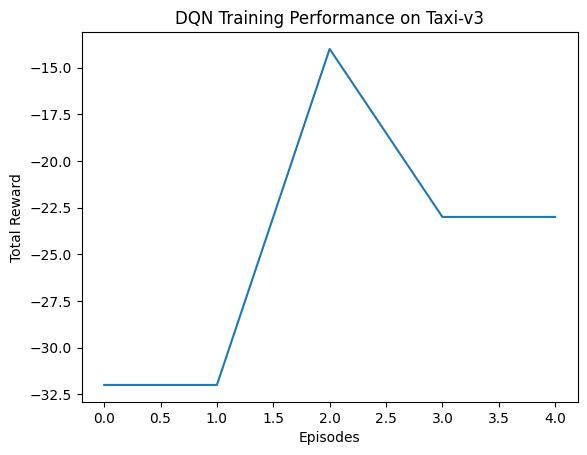

In [13]:
# Plot training rewards
plt.plot(reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance on Taxi-v3')
plt.show()

In [14]:
print("\nOptimal Policy for Taxi-v3 Environment:\n")

for state in range(state_size):
    state_tensor = torch.eye(state_size)[state].unsqueeze(0)  # Convert state to one-hot encoding
    with torch.no_grad():
        action = torch.argmax(policy_net(state_tensor)).item()  # Get best action

    print(f"State {state}: {action}")


Optimal Policy for Taxi-v3 Environment:

State 0: 1
State 1: 1
State 2: 1
State 3: 1
State 4: 1
State 5: 1
State 6: 1
State 7: 1
State 8: 1
State 9: 1
State 10: 1
State 11: 1
State 12: 1
State 13: 1
State 14: 1
State 15: 1
State 16: 1
State 17: 1
State 18: 1
State 19: 1
State 20: 1
State 21: 1
State 22: 1
State 23: 1
State 24: 1
State 25: 1
State 26: 1
State 27: 1
State 28: 1
State 29: 1
State 30: 1
State 31: 1
State 32: 1
State 33: 1
State 34: 1
State 35: 1
State 36: 1
State 37: 1
State 38: 1
State 39: 1
State 40: 1
State 41: 1
State 42: 1
State 43: 1
State 44: 1
State 45: 1
State 46: 1
State 47: 1
State 48: 1
State 49: 1
State 50: 1
State 51: 1
State 52: 1
State 53: 1
State 54: 1
State 55: 1
State 56: 1
State 57: 1
State 58: 1
State 59: 1
State 60: 1
State 61: 1
State 62: 1
State 63: 1
State 64: 1
State 65: 1
State 66: 1
State 67: 1
State 68: 1
State 69: 1
State 70: 1
State 71: 1
State 72: 1
State 73: 1
State 74: 1
State 75: 1
State 76: 1
State 77: 1
State 78: 1
State 79: 1
State 80

In [15]:
# Test the trained DDQN policy
def test_ddqn_policy(test_episodes=10, max_steps=10):
    total_rewards = []
    for _ in range(test_episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        for _ in range(max_steps):
            state_tensor = torch.eye(state_size)[state].unsqueeze(0)
            with torch.no_grad():
                action = torch.argmax(policy_net(state_tensor)).item()
            state, reward, done, truncated, _ = env.step(action)
            ep_reward += reward
            if done:
                break
        total_rewards.append(ep_reward)
    
    print(f"\nAverage Reward over {test_episodes} test episodes: {np.mean(total_rewards):.2f}")

# Run test
test_ddqn_policy()


Average Reward over 10 test episodes: -10.00


Sources / References: 

1. https://gymnasium.farama.org/environments/toy_text/taxi/
2. https://github.com/rajibhossen/dqn-examples/blob/master/taxi-v3-dqn.py
3. https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b/